In [1]:
import sys
sys.path.append("..")

from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from time import localtime, strftime, strptime
import os
from D2.data_selector import DataSelector
import seaborn as sns

SEED = 42

In [2]:
ds = DataSelector("../D2/data.csv")
data = ds.select_data(30000, length=5, scale_sd=30, seed=SEED)
data['conversation'] = data['conversation'].astype(str)

/home/alexlu/Documents/Programming/alexlu07/Scires/11th/VAD/M1.5/../D2/data_selector.py:10: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(filepath)


Filtering...
Calculating counts...
Grabbing data...


In [3]:
raw_dataset = Dataset.from_pandas(data)
train_testval = raw_dataset.train_test_split(test_size=0.2, seed=SEED)
test_val = train_testval['test'].train_test_split(test_size=0.5, seed=SEED)

dataset = DatasetDict({
    'train': train_testval['train'],
    'test': test_val['test'],
    'val': test_val['train']}
)

In [4]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def mask_data(mask_ratio):
    def mask_function(examples):
        mask_idx = np.random.choice(len(examples["text"]), int(mask_ratio * len(examples["text"])), replace=False)
        convs = examples["text"]
        for i in mask_idx:
            convs[i][-1] = tokenizer.mask_token
        
        return {"text": convs}

    return mask_function

def preprocess_data(examples):
    role_names = ("speaker", "respondent")

    convs = [
        tokenizer.apply_chat_template(
            [{"role": role_names[i % 2], "content": x} for i, x in enumerate(m)], 
            tokenize=False)
        for m in examples["text"]
    ]

    encoding = tokenizer(convs, max_length=512, truncation=True)
    encoding["labels"] = list(zip(examples["V"], examples["A"], examples["D"]))

    return encoding

test_dataset = dataset["test"].map(mask_data(1), batched=True, batch_size=100000)
tokenized_test_dataset = test_dataset.map(preprocess_data, batched=True, batch_size=100000)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]


No chat template is defined for this tokenizer - using a default chat template that implements the ChatML format (without BOS/EOS tokens!). If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



In [6]:
def get_checkpoint(epoch=0, run="latest", folder_path="results"):
    if run == "latest":
        run = max(os.listdir(folder_path), key=lambda x: strptime(x, "%b-%d-%y-%H:%M:%S"))

    checkpoint = sorted(os.listdir(f"{folder_path}/{run}"), key=lambda x: int(x.split("-")[1]))[epoch-1]

    return f"{folder_path}/{run}/{checkpoint}"

# c = get_checkpoint(3, "Dec-31-23-19:08:36")
c = get_checkpoint(15)
model = AutoModelForSequenceClassification.from_pretrained(c)

In [7]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = 4/(1+np.exp(-logits)) + 1

    metrics = {
        "mae": mean_absolute_error(labels, logits, multioutput="raw_values").tolist(),
        "mse": mean_squared_error(labels, logits, multioutput="raw_values").tolist(),
        "pearsonr": [pearsonr(logits[:, i], labels[:, i])[0] for i in range(len(logits[0]))],
        "r_squared": r2_score(labels, logits, multioutput="raw_values").tolist(),
    }

    return {f"{m}_{s}": metrics[m][i] for i, s in enumerate("VAD") for m in metrics}

In [8]:
class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = torch.sigmoid(outputs['logits']) * 4 + 1
        loss = torch.nn.functional.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [9]:
training_args = TrainingArguments(
    output_dir="/tmp/tmp_trainer",
    per_device_eval_batch_size=26,
    report_to="none",
)

trainer = RegressionTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

In [10]:
trainer.evaluate(tokenized_test_dataset)

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.19980108737945557,
 'eval_mae_V': 0.504207193851471,
 'eval_mse_V': 0.4321118891239166,
 'eval_pearsonr_V': 0.4794396355476272,
 'eval_r_squared_V': 0.14698675931736271,
 'eval_mae_A': 0.2820039689540863,
 'eval_mse_A': 0.11818049103021622,
 'eval_pearsonr_A': 0.47132203654491467,
 'eval_r_squared_A': 0.18242658302238524,
 'eval_mae_D': 0.1664951890707016,
 'eval_mse_D': 0.04911014810204506,
 'eval_pearsonr_D': 0.3727314555989004,
 'eval_r_squared_D': 0.09558118610492605,
 'eval_runtime': 10.8699,
 'eval_samples_per_second': 275.991,
 'eval_steps_per_second': 10.672}

In [11]:
predictions = trainer.predict(tokenized_test_dataset)

  0%|          | 0/116 [00:00<?, ?it/s]

In [12]:
preds = pd.DataFrame(dataset["test"])[["text", "V", "A", "D"]]
preds[["V_hat", "A_hat", "D_hat"]] = 4/(1+np.exp(-predictions[0])) + 1

In [13]:
preds

text         V         A  \
0     [No, not enough of us were free, Probably for ...  2.989412  2.936445   
1     [as a cashier or something, don't let them tie...  2.156965  3.496695   
2     [Yeah of course! I'm back already so let me kn...  2.970068  2.946359   
3     [Glad you were able to find rest. Anything els...  2.256102  3.276690   
4     [I got stuck. I have about 25 pages., If I hav...  3.015229  2.934204   
...                                                 ...       ...       ...   
2995  [You are taking over the Zoe walks this aftern...  2.946375  2.829934   
2996  [Hahahaha, You welcome., This lady's freaking ...  3.349152  3.764826   
2997  [I'll be there!!, Whee call dori if u wnna wal...  2.264295  3.270882   
2998  [I just did babe, Hehehe, We're perfectl, I kn...  4.261306  3.788481   
2999  [So I finally figured out why I'm breaking out...  3.890736  3.647828   

             D     V_hat     A_hat     D_hat  
0     3.096755  3.005648  3.176629  3.013095  
1     2.796427  3.242702  3.435584  3.059920  
2     3.011628  3.467198  3.474829  3.102415  
3     2.653065  2.461137  3.389969  2.874731  
4     3.086980  2.879758  3.241192  3.050240  
...        ...       ...       ...       ...  
2995  3.035416  3.486706  3.403708  3.113879  
2996  3.257132  3.601297  3.668980  3.130212  
2997  2.582529  3.544165  3.626707  3.141531  
2998  3.036775  3.849302  3.909240  3.235300  
2999  3.210234  2.233017  3.432488  2.778551  

[3000 rows x 7 columns]

In [14]:
preds_it = preds.iterrows()

They hadn't arrived yet, 239, 230, ￼, No one is mentioning the ideal or real
that's ok. in fact, they shd be. you will be fine. you will be fascinating. is anyone talking about dynamic media, or new media?, is it interesting
No, Toplessness , And now Balkan/ Albanian bomb bunkers
i think that if you can communicate your ideas clearly, you'll be a fascinating addition to this symposium. , are they interesting?
Everyone is just reading, I can't focus


[(1.0, 5.0)]

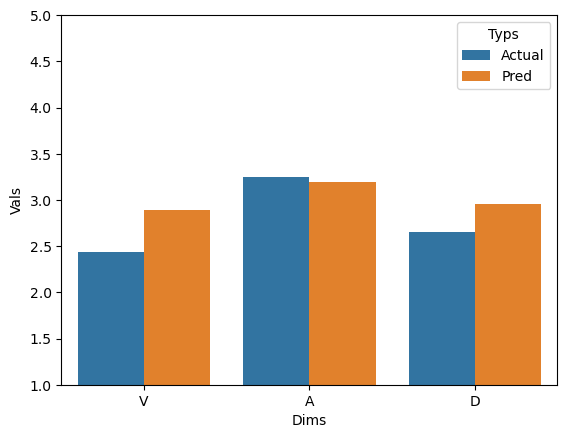

In [27]:
row = next(preds_it)[1]
for i in row["text"]: print(i)

vals = row[list("VAD")].tolist() + [row["V_hat"], row["A_hat"], row["D_hat"]]
dims = list("VAD") * 2
typs = ["Actual"] * 3 + ["Pred"] * 3
bar_df = pd.DataFrame({"Vals": vals, "Dims": dims, "Typs": typs})

ax = sns.barplot(bar_df, x="Dims", y="Vals", hue="Typs",)
ax.set(ylim=(1, 5))

<Axes: xlabel='D', ylabel='D_hat'>

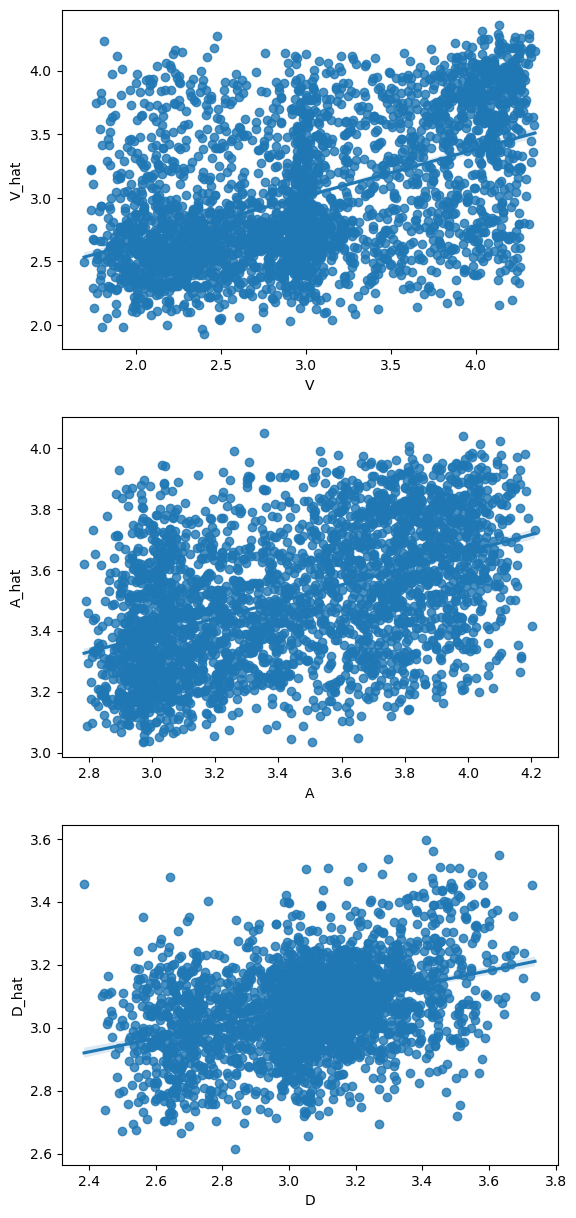

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=3)
fig.set_figheight(15)
sns.regplot(preds, x="V", y="V_hat", ax=axs[0])
sns.regplot(preds, x="A", y="A_hat", ax=axs[1])
sns.regplot(preds, x="D", y="D_hat", ax=axs[2])

In [35]:
def loop():
    fig, axs = plt.subplots(nrows=20, ncols=3)
    fig.set_figwidth(20)
    fig.set_figheight(100)

    for i in range(1, 21):
        c = get_checkpoint(i)
        model = AutoModelForSequenceClassification.from_pretrained(c)

        trainer = RegressionTrainer(
            model=model,
            args=training_args,
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )
        predictions = trainer.predict(tokenized_test_dataset)
        preds = pd.DataFrame(dataset["test"])[["text", "V", "A", "D"]]
        preds[["V_hat", "A_hat", "D_hat"]] = 4/(1+np.exp(-predictions[0])) + 1

        sns.regplot(preds, x="V", y="V_hat", ax=axs[i-1][0])
        sns.regplot(preds, x="A", y="A_hat", ax=axs[i-1][1])
        sns.regplot(preds, x="D", y="D_hat", ax=axs[i-1][2])



  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

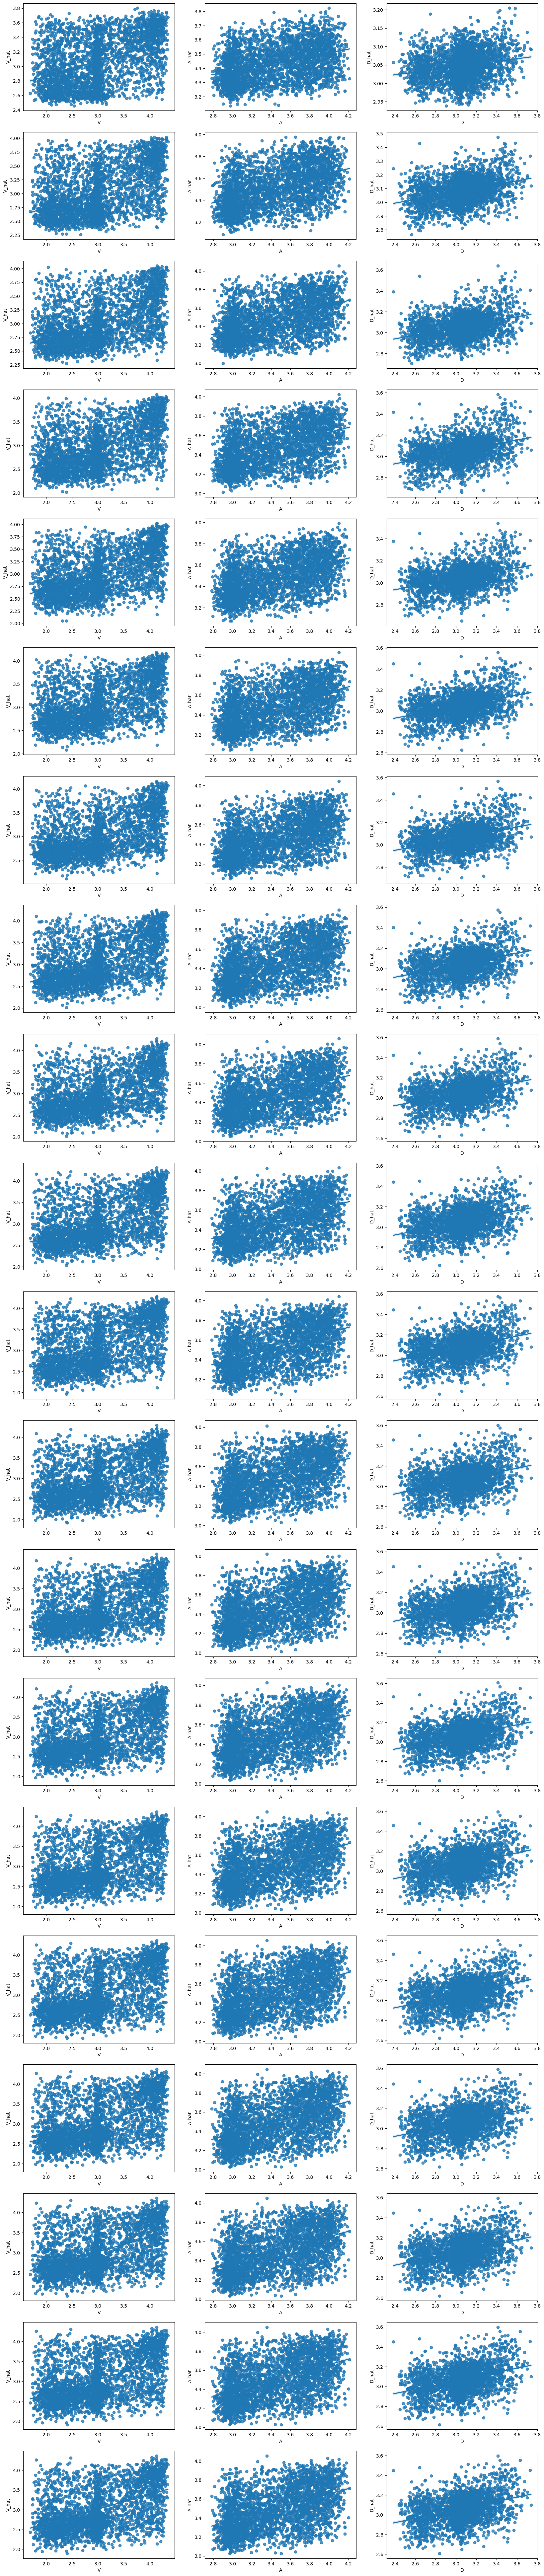

In [36]:
loop()

In [66]:
c = get_checkpoint(3)
model = AutoModelForSequenceClassification.from_pretrained(c)
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [94]:
text_inputs = [
    [
        "i just lost my job today. it's devastating", 
        "i just found a job today, i'm so happy", 
        "this is miserable. i feel like a failure.", 
        "i can't believe my good fortune!",
        "will you just shut up?",
    ], [
        "I just got a promotion at work! I'm so excited and proud of myself!",
        "Wow, that's fantastic news! Congratulations! 🎉",
        "Thanks! It's been a long journey, but I finally feel recognized for my efforts.",
        "I can imagine the hard work you've put in. Your dedication has paid off. How do you feel now?",
        "well actually, i feel sad",
    ], [
        "i just lost everything that mattered to me. there's no point in life anymore", 
        "life is meaningless anyways", 
        "what should i do now? what can i even do now", 
        "it's hopeless. there's no point in doing anything. life is sad",
        "yeah",
    ], [
        "i just lost everything that mattered to me. there's no point in life anymore", 
        "don't worry, i got you. look at all these good things!", 
        "oh wow, thanks! what should i do now? i'm happy", 
        "just stay optimistic. don't give up.",
        "yeah",
    ],
]

role_names = ["speaker", "respondent"]
text_inputs = [tokenizer.apply_chat_template(
                   [{"role": role_names[i % 2], "content": x} for i, x in enumerate(m)], 
                   tokenize=False)
              for m in text_inputs
]

In [95]:
from transformers import TextClassificationPipeline

class RegPipeline(TextClassificationPipeline):
    def postprocess(self, model_outputs):
        best_class = model_outputs["logits"]
        return torch.sigmoid(best_class) * 4 + 1
    
pipe = RegPipeline(model=model, tokenizer=tokenizer)

In [96]:
pipe(text_inputs)

[tensor([[2.3513, 3.4778, 3.0258]]),
 tensor([[1.9067, 3.4729, 2.3674]]),
 tensor([[2.5518, 3.0359, 2.8733]]),
 tensor([[2.8778, 2.9722, 2.9646]])]

In [101]:
trainer.callback_handler.on_epoch_end

<bound method CallbackHandler.on_epoch_end of <transformers.trainer_callback.CallbackHandler object at 0x7f540e47ab50>>